In [69]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold

import catboost as ctb

import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings("ignore")


In [70]:
#Data
df_sales_train = pd.read_hdf("Data/sales_train.h5")
df_sales_test = pd.read_hdf("Data/sales_test.h5")



df_sales_train["date"] = pd.to_datetime(df_sales_train["date"],dayfirst=True)

df_sales_train = df_sales_train.sort_values(by=["store", "dept", "date"])
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"], dayfirst=True)

df_sales_train.head(10)

,id,weekly_sales,store,dept,date,is_holiday
134438,134438,24924.500000,1,1,2010-02-05,False
418402,418402,46039.488281,1,1,2010-02-12,True
115305,115305,41595.550781,1,1,2010-02-19,False
351187,351187,19403.539062,1,1,2010-02-26,False
91151,91151,21827.900391,1,1,2010-03-05,False
157905,157905,21043.390625,1,1,2010-03-12,False
72620,72620,22136.640625,1,1,2010-03-19,False
384329,384329,26229.210938,1,1,2010-03-26,False
81351,81351,57258.429688,1,1,2010-04-02,False
219935,219935,42960.910156,1,1,2010-04-09,False


## Feature engineering

In [71]:
def data_engineering(df):                       #Feats from date
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["week"] = df["date"].dt.week
    df["month"] = df["date"].dt.month

    
    return df

df_sales_train = data_engineering(df_sales_train)
df_sales_test = data_engineering(df_sales_test)

In [72]:
# Extra features
df_features_train = pd.read_hdf("Data/features_train.h5")
df_features_test = pd.read_hdf("Data/features_test.h5")


### Store data

In [73]:
df_stores_data = pd.read_csv("Data/stores_data(1).csv")
df_stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [74]:
df_stores_data['Type_cat']=df_stores_data['Type'].factorize()[0] #categorizing "Type" feat
df_stores_data.groupby('Type').Size.describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.727273,49392.621098,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.705882,32371.137916,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.666667,1304.145033,39690.0,39745.00,39910.0,40774.0,42988.0


In [75]:
#Creating dict {'Store':"Size"} and {'Store':"Type_cat"}
train_dict_Size = { x["Store"]: x["Size"] for x in df_stores_data.to_dict('index').values() }
train_dict_Type = { x["Store"]: x["Type_cat"] for x in df_stores_data.to_dict('index').values() }

In [76]:
#Adding "Type" and "Surface" feature to train and test df
df_sales_train["Type"] = df_sales_train.apply(lambda x: train_dict_Type.get( x["store"], -1), axis=1)
df_sales_train["Surface"] = df_sales_train.apply(lambda x: train_dict_Size.get( x["store"], -1), axis=1)

df_sales_test["Type"] = df_sales_test.apply(lambda x: train_dict_Type.get( x["store"], -1), axis=1)
df_sales_test["Surface"] = df_sales_test.apply(lambda x: train_dict_Size.get( x["store"], -1), axis=1)


### Fuel, Unemployment, CPI

In [77]:
df_features_train["date"] = pd.to_datetime(df_features_train["date"])
df_features_train= df_features_train.sort_values(by=["store", "date"])

df_features_test["date"] = pd.to_datetime(df_features_test["date"])


In [78]:
df_features_train = feature_engineering(df_features_train)
df_features_test = feature_engineering(df_features_test)

In [79]:
df_feat = df_features_train[ ["store",'month', "week",'fuel_price'] ].groupby(["store", "month"]).agg(["mean", "std", "median", "size"])["fuel_price"].reset_index()
df_feat = df_feat.rename(columns = {'size':'size_fuel','mean':'mean_fuel','std':'std_fuel', 'median':'median_fuel'})


In [80]:
df_sales_train_ext = pd.merge(df_sales_train_ext, df_feat, on=["store", "month"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test_ext, df_feat, on=["store", "month"], how="left").fillna(-1)

In [81]:
df_feat_unemployment = df_features_train[ ["store",'month', "week",'unemployment'] ].groupby(["store", "month"]).agg(["mean", "std", "median", "size"])["unemployment"].reset_index()
df_feat_unemployment = df_feat_unemployment.rename(columns = {'size':'size_unemp','mean':'mean_unemp','std':'std_unemp', 'median':'median_unemp'})

In [82]:
df_feat_cpi = df_features_train[ ["store",'month', "week",'cpi'] ].groupby(["store", "month"]).agg(["mean", "std", "median", "size"])["cpi"].reset_index()
df_feat_cpi = df_feat_cpi.rename(columns = {'size':'size_cpi','mean':'mean_cpi','std':'std_cpi', 'median':'median_cpi'})

In [83]:
df_sales_train_ext = pd.merge(df_sales_train_ext, df_feat_unemployment, on=["store", "month"], how="left").fillna(-1)
df_sales_train_ext = pd.merge(df_sales_train_ext, df_feat_cpi, on=["store", "month"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test_ext, df_feat_unemployment, on=["store", "month"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test_ext, df_feat_cpi, on=["store", "month"], how="left").fillna(-1)
df_sales_train_ext.head()

,id,weekly_sales,store,dept,date,is_holiday,is_holiday_cat,dayofweek,dayofyear,week,...,median_fuel_y,size_fuel_y,mean_unemp,std_unemp,median_unemp,size_unemp,mean_cpi,std_cpi,median_cpi,size_cpi
0,134438,24924.500000,1,1,2010-02-05,False,0,4,36,5,...,2.882812,8,7.890625,0.152651,7.835938,8,213.25,2.770218,212.250,8
1,418402,46039.488281,1,1,2010-02-12,True,1,4,43,6,...,2.882812,8,7.890625,0.152651,7.835938,8,213.25,2.770218,212.250,8
2,115305,41595.550781,1,1,2010-02-19,False,0,4,50,7,...,2.882812,8,7.890625,0.152651,7.835938,8,213.25,2.770218,212.250,8
3,351187,19403.539062,1,1,2010-02-26,False,0,4,57,8,...,2.882812,8,7.890625,0.152651,7.835938,8,213.25,2.770218,212.250,8
4,91151,21827.900391,1,1,2010-03-05,False,0,4,64,9,...,2.732422,7,7.859375,0.177601,7.785156,7,212.75,1.849630,211.625,7


In [ ]:
# Categorizing is_holiday
def cat_eng(df):
    factorized_values = df['is_holiday'].factorize()[0]
    df['is_holiday' + '_cat'] = factorized_values
    return df
    
df_sales_train = cat_eng(df_sales_train)
df_sales_test = cat_eng(df_sales_test)



### Analysing sample sale

<AxesSubplot:xlabel='dept', ylabel='mean'>

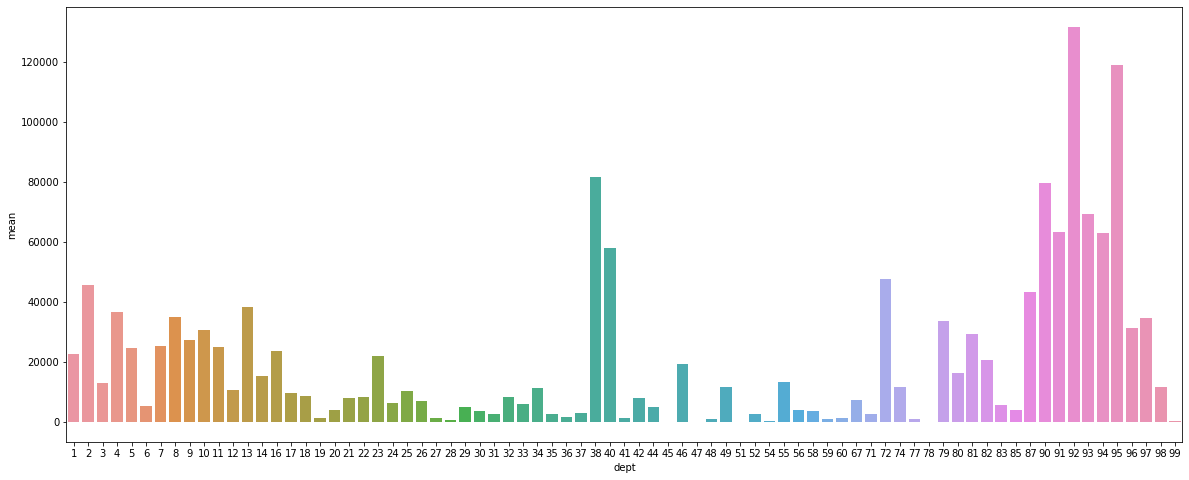

In [58]:
df_dep = df_sales_train[ ["store", "dept",'month', "weekly_sales"] ].groupby(["store", "dept"]).agg(["mean", "std", "median", "size"])["weekly_sales"].reset_index()
plt.figure(figsize = (20,8))
sns.barplot(data = df_dep[df_dep['store']==1], x = 'dept', y = 'mean') # Analysing mean sale by store and dept

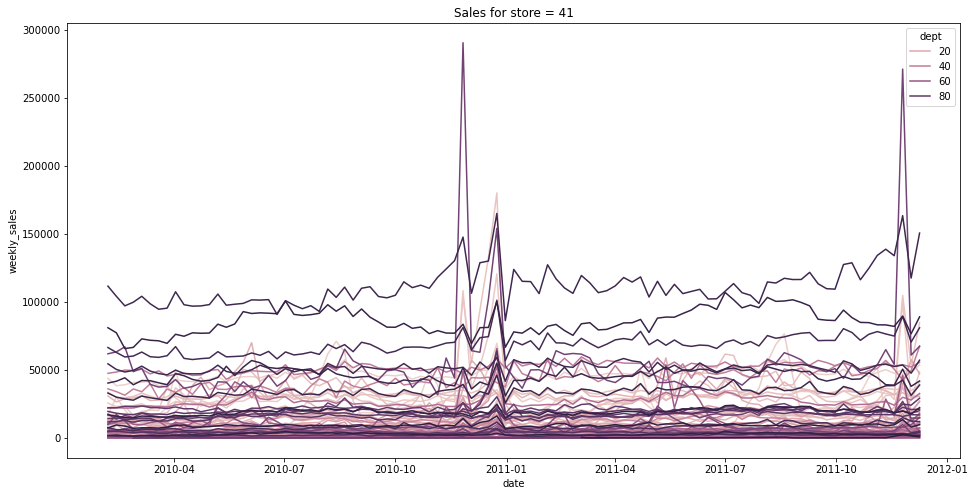

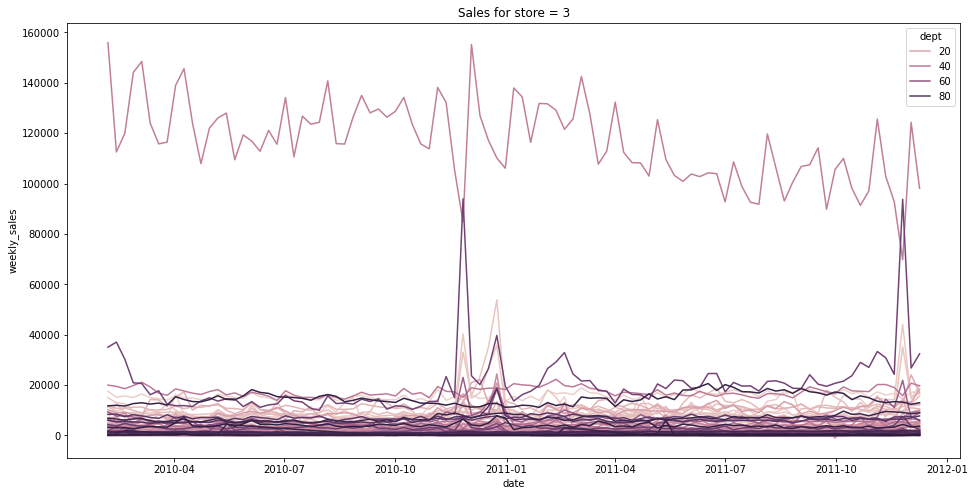

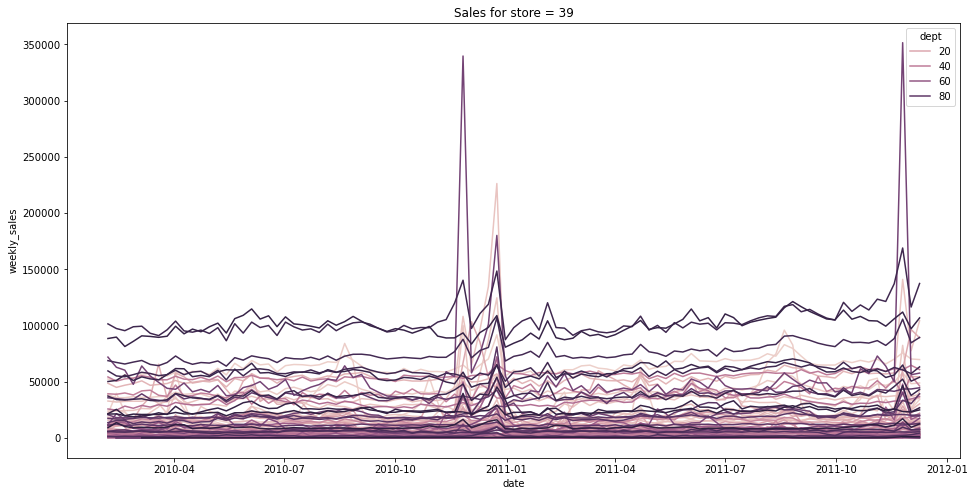

In [61]:
df_sales_train_ext = pd.merge(df_sales_train, df_dep, on=["store", "dept"], how="left").fillna(-1)
df_sales_test_ext = pd.merge(df_sales_test, df_dep, on=["store", "dept"], how="left").fillna(-1)
df_sales_train_ext.head()
for i in range(3):
    random_store = df_sales_train_ext.store.sample().values[0]
    plt.figure(figsize = (16,8))
    plt.title("Sales for store = {}".format(random_store))
    sns.lineplot(x='date', y='weekly_sales', hue="dept", data=df_sales_train_ext[df_sales_train_ext.store == random_store]);
    plt.show()

# Modeling

In [18]:
def run_model(model,feats):
  X = X_train
  y = np.log(y_train - np.min(y_train)+1)

  scores = cross_val_score(model, X, y, cv = 3, scoring = 'neg_mean_absolute_error')
  return np.mean(scores), np.std(scores)

In [19]:
feats = ['store', 'dept', 'Type','size',
       'Surface', 'is_holiday_cat', 'dayofweek', 'dayofyear', 'week', 'month',
       'mean', 'std', 'median', 'mean_fuel', 'std_fuel', 'median_fuel',
        'mean_unemp', 'std_unemp', 'median_unemp',
       'mean_cpi', 'std_cpi', 'median_cpi']
#'median_fuel', 'mean_unemp', 'std_unemp', 'median_unemp','mean', 'std', 'median']
X_train = df_sales_train_ext[ feats ].values
X_test = df_sales_test_ext[ feats ].values

y_train = df_sales_train_ext["weekly_sales"].values
X_train = X_train[ y_train > 0 ]
y_train = y_train[ y_train > 0 ]
y_train_log = np.log(y_train - np.min(y_train) + 1)

In [ ]:
run_model(RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0),X_train)

In [21]:
xgb_params = {
    'max_depth': 9,
            'colsample_bytree': 0.9,
            'learning_rate': 0.15,
            'subsample': 0.9,
            'random_state': 21,
            'n_estimators':500,
}
#run_model(xgb.XGBRegressor(**xgb_params), feats)

In [303]:
m = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)
m.fit(X_train, y_train_log)
imp = PermutationImportance(m).fit(X_train, y_train_log)
eli5.show_weights(imp,feature_names = feats)

Weight,Feature
1.5605 ± 0.0057,dept
0.6038 ± 0.0061,Surface
0.2578 ± 0.0031,store
0.0486 ± 0.0008,Type
0.0111 ± 0.0001,dayofyear
0.0084 ± 0.0007,std_fuel
0.0066 ± 0.0002,week
0.0049 ± 0.0004,dayofweek
0.0038 ± 0.0001,std_unemp
0.0037 ± 0.0001,mean_unemp


In [22]:
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train_log)
imp = PermutationImportance(m).fit(X_train, y_train_log)
eli5.show_weights(imp,feature_names = feats)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

# File

In [23]:
df_sales_test["weekly_sales"] = np.exp(model.predict(X_test))
df_sales_test[ ["id", "weekly_sales"] ].to_csv("Data/ML_prediction.csv", index=False)